# 9. Encoder-Decoder for converting dates

_Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22")._

## Set up environment

In [35]:
import datetime

import random

from sklearn.model_selection import train_test_split

import keras

import keras_hub

import tensorflow as tf

import numpy as np

## Prepare data

In [2]:
SAMPLE_SIZE = 10000

In [3]:
def generate_random_dates(start_year, end_year, count):
    random_dates = []
    for _ in range(count):
        year = random.randint(start_year, end_year)
        month = random.randint(1, 12)
        day = random.randint(1, 28)  # To avoid invalid dates
        random_date = datetime.date(year, month, day)
        random_dates.append(random_date)
    return random_dates

In [4]:
dates = generate_random_dates(1900, 2023, SAMPLE_SIZE)
X = [date.strftime("%B %d, %Y") for date in dates]
y = list(map(lambda date: date.isoformat(), dates))

In [5]:
X[:5]

['September 12, 1961',
 'February 23, 1931',
 'February 27, 1985',
 'August 16, 2006',
 'July 21, 1909']

In [6]:
y[:5]

['1961-09-12', '1931-02-23', '1985-02-27', '2006-08-16', '1909-07-21']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(len(X_train))
print(len(X_valid))
print(len(X_test))

8000
1000
1000


## Train model

In [8]:
START_OF_SEQ = "<"
END_OF_SEQ = ">"
DELIMITER = "-"

In [9]:
DAYS_MONTHS = [f"{day:02}" for day in range(1, 32)]
MONTHS = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
YEARS = [str(year) for year in range (1900, 2100)]

In [10]:
@tf.function
def split_dash(input_str):
  return tf.strings.split(input_str, sep="-")

In [11]:
text_vec_layer_read = keras.layers.TextVectorization(standardize="strip_punctuation",
    vocabulary=DAYS_MONTHS + MONTHS + YEARS
)

text_vec_layer_iso = keras.layers.TextVectorization(standardize=None, split=split_dash,
    vocabulary=DAYS_MONTHS + YEARS + [START_OF_SEQ, END_OF_SEQ, DELIMITER]
)

I0000 00:00:1742805018.393690   43381 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [12]:
VOCAB_SIZE_READ = text_vec_layer_read.vocabulary_size()
print(f"Readable format vocabulary size is {VOCAB_SIZE_READ}")

VOCAB_SIZE_ISO = text_vec_layer_iso.vocabulary_size()
print(f"ISO format vocabulary size is {VOCAB_SIZE_ISO}")

Readable format vocabulary size is 245
ISO format vocabulary size is 236


In [13]:
print(text_vec_layer_read.get_vocabulary())

['', '[UNK]', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984'

In [14]:
print(text_vec_layer_iso.get_vocabulary())

['', '[UNK]', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', 

In [15]:
print(text_vec_layer_read("November 02, 1966"))
print(text_vec_layer_iso(f"{START_OF_SEQ}-1932-10-24-{END_OF_SEQ}"))

tf.Tensor([ 43   3 111], shape=(3,), dtype=int64)
tf.Tensor([233  65  11  25 234], shape=(5,), dtype=int64)


In [16]:
EMBED_SIZE_ISO = VOCAB_SIZE_ISO // 2
EMBED_SIZE_READ = VOCAB_SIZE_READ // 2

MAX_OUTPUT_LENGTH = 3 # number of tokens to predict is constant (e.g. [2019, 04, 22])

#### Simple seq2seq model

Adapted from [exercise solution](https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb) to use words instead of chars.

In [17]:
X_train_vec = text_vec_layer_read(X_train)
X_valid_vec = text_vec_layer_read(X_valid)
X_test_vec = text_vec_layer_read(X_test)

y_train_vec = text_vec_layer_iso(y_train)
y_valid_vec = text_vec_layer_iso(y_valid)
y_test_vec = text_vec_layer_iso(y_test)

In [18]:
print(X_train_vec[:5])

tf.Tensor(
[[ 40  19 163]
 [ 35   7  92]
 [ 39  15 147]
 [ 43  20 164]
 [ 38  14 121]], shape=(5, 3), dtype=int64)


In [19]:
print(y_train_vec[:5])

tf.Tensor(
[[151   9  19]
 [ 80   4   7]
 [135   8  15]
 [152  12  20]
 [109   7  14]], shape=(5, 3), dtype=int64)


In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

encoder = keras.Sequential(
    [
        keras.layers.Embedding(
            input_dim=VOCAB_SIZE_READ,
            output_dim=EMBED_SIZE_READ,
            input_shape=[None],
        ),
        keras.layers.LSTM(128),
    ]
)

decoder = keras.Sequential(
    [
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.Dense(VOCAB_SIZE_ISO, activation="softmax"),
    ]
)

model = keras.Sequential(
    [encoder, keras.layers.RepeatVector(MAX_OUTPUT_LENGTH), decoder]
)

optimizer = keras.optimizers.Nadam()
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    X_train_vec,
    y_train_vec,
    epochs=20,
    validation_data=(X_valid_vec, y_valid_vec),
    callbacks=[early_stopping_cb],
)

/home/martin/miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1742805020.927772   43462 cuda_dnn.cc:529] Loaded cuDNN version 90700


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.0778 - loss: 4.3138 - val_accuracy: 0.3720 - val_loss: 2.6002
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4693 - loss: 2.3298 - val_accuracy: 0.6557 - val_loss: 1.8010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6740 - loss: 1.6658 - val_accuracy: 0.7373 - val_loss: 1.3827
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8508 - loss: 1.0934 - val_accuracy: 0.9880 - val_loss: 0.5096
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9967 - loss: 0.3371 - val_accuracy: 0.9980 - val_loss: 0.1580
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9999 - loss: 0.1063 - val_accuracy: 0.9993 - val_loss: 0.0741
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.0520 - val_accuracy: 1.0000 - val_loss: 0.0447
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.0000 - loss: 0.0316 - val_accuracy: 1.000

In [21]:
model.evaluate(X_test_vec, y_test_vec)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024


[0.0024165837094187737, 1.0]

In [22]:
def convert_simple(date_read):
    date_vec = text_vec_layer_read([date_read]) # needs to pass array because that is the shape that the model was train on
    predictions = model.predict(date_vec)
    
    word_idxs = np.argmax(predictions, axis=2) # choose word indexes with highest probability
    word_idxs = word_idxs.reshape((-1)) # drop first axis (we are only passing single date)

    result = []
    for index in word_idxs:
        result.append(text_vec_layer_iso.get_vocabulary()[index])

    return DELIMITER.join(result)

result = convert_simple("April 22, 2019")
assert result == "2019-04-22"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


#### Encoder-Decoder

Inspired by code examples from [the Hands on ML book](https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb).

In [23]:
X_train = tf.constant(X_train)
X_valid = tf.constant(X_valid)
X_test = tf.constant(X_test)

X_train_dec = tf.constant([f"{START_OF_SEQ}-{date}" for date in y_train])
X_valid_dec = tf.constant([f"{START_OF_SEQ}-{date}" for date in y_valid])
X_test_dec = tf.constant([f"{START_OF_SEQ}-{date}" for date in y_test])

y_train_dec = text_vec_layer_iso([f"{date}-{END_OF_SEQ}" for date in y_train])
y_valid_dec = text_vec_layer_iso([f"{date}-{END_OF_SEQ}" for date in y_valid])
y_test_dec = text_vec_layer_iso([f"{date}-{END_OF_SEQ}" for date in y_test])

In [24]:
text_vec_layer_read(X_train[:5])

<tf.Tensor: shape=(5, 3), dtype=int64, numpy=
array([[ 40,  19, 163],
       [ 35,   7,  92],
       [ 39,  15, 147],
       [ 43,  20, 164],
       [ 38,  14, 121]])>

In [25]:
text_vec_layer_iso(X_train_dec[:5])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[233, 151,   9,  19],
       [233,  80,   4,   7],
       [233, 135,   8,  15],
       [233, 152,  12,  20],
       [233, 109,   7,  14]])>

In [26]:
y_train_dec[:5]

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[151,   9,  19, 234],
       [ 80,   4,   7, 234],
       [135,   8,  15, 234],
       [152,  12,  20, 234],
       [109,   7,  14, 234]])>

In [27]:
encoder_inputs = keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = keras.layers.Input(shape=[], dtype=tf.string)

In [28]:
encoder_input_ids = text_vec_layer_read(encoder_inputs)
decoder_input_ids = text_vec_layer_iso(decoder_inputs)

encoder_embedding_layer = keras.layers.Embedding(
    VOCAB_SIZE_READ, EMBED_SIZE_READ
)
decoder_embedding_layer = keras.layers.Embedding(
    VOCAB_SIZE_ISO, EMBED_SIZE_ISO
)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [29]:
encoder = keras.layers.LSTM(128, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [30]:
decoder = keras.layers.LSTM(128, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [31]:
output_layer = keras.layers.Dense(VOCAB_SIZE_ISO, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [32]:
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
model.fit(
    (X_train, X_train_dec),
    y_train_dec,
    epochs=10,
    validation_data=((X_valid, X_valid_dec), y_valid_dec),
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.2810 - loss: 3.6668 - val_accuracy: 0.5863 - val_loss: 1.8001
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.6936 - loss: 1.5101 - val_accuracy: 0.8960 - val_loss: 0.8791
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9627 - loss: 0.6029 - val_accuracy: 0.9998 - val_loss: 0.1412
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 1.0000 - loss: 0.0942 - val_accuracy: 1.0000 - val_loss: 0.0464
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 1.0000 - loss: 0.0343 - val_accuracy: 1.0000 - val_loss: 0.0241
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 1.0000 - loss: 0.0081 - val_acc

In [33]:
model.evaluate((X_test, X_test_dec), y_test_dec)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0044


[0.004451965447515249, 1.0]

In [34]:
def convert_encoder_decoder(date_read):
    # Convert the input date to a tensor using the text vectorization layer
    date_vec = tf.constant([date_read])  # Pass as a list

    # Initialize the decoder input with the SOS
    decoder_input = tf.constant([f"{START_OF_SEQ}"])

    # Iterate over the maximum output length
    for _ in range(MAX_OUTPUT_LENGTH):
        # Predict the next token
        predictions = model.predict([date_vec, decoder_input])
        next_token_id = np.argmax(
            predictions[0, -1, :]
        )  # Get the token with the highest probability

        next_token = text_vec_layer_iso.get_vocabulary()[next_token_id]
        print(next_token)

        # Update the decoder input for the next iteration
        decoder_input = tf.strings.join(
            [decoder_input, tf.constant([f"{DELIMITER}{next_token}"])]
        )

    # Remove Start of Sequence (+ Delimiter) from decoder input to get final predicted result
    result = tf.strings.regex_replace(decoder_input, "<-", "")
    return result


result = convert_encoder_decoder("April 22, 2019")
assert result == "2019-04-22"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
2019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
22


#### Transformer

Inspired by code examples from [the Hands on ML book](https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb).

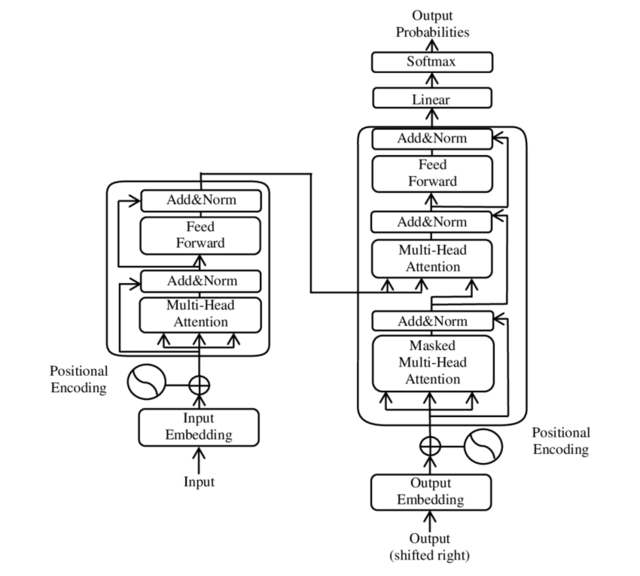

In [66]:
max_length = 4

In [67]:
# TODO: try replacing with https://keras.io/keras_hub/api/modeling_layers/sine_position_encoding/

class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [68]:
# (Changed) Created separate PositionalEncodings
pos_embed_layer_enc = PositionalEncoding(max_length, EMBED_SIZE_READ)
pos_embed_layer_dec = PositionalEncoding(max_length, EMBED_SIZE_ISO)

encoder_in = pos_embed_layer_enc(encoder_embeddings)
decoder_in = pos_embed_layer_dec(decoder_embeddings)

In [69]:
N = 2  # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # for the first Dense layer in each Feed Forward block

# (Changed) Wrapped tensor into Layer
encoder_pad_mask_layer = keras.layers.Lambda(lambda x: tf.math.not_equal(x, 0)[:, tf.newaxis])
encoder_pad_mask = encoder_pad_mask_layer(encoder_input_ids)

Z = encoder_in
for _ in range(N):
    skip = Z
    
    attn_layer = keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=EMBED_SIZE_READ, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)

    Z = keras.layers.LayerNormalization()(keras.layers.Add()([Z, skip]))
    
    skip = Z
    Z = keras.layers.Dense(n_units, activation="relu")(Z)
    Z = keras.layers.Dense(EMBED_SIZE_READ)(Z)
    Z = keras.layers.Dropout(dropout_rate)(Z)
    Z = keras.layers.LayerNormalization()(keras.layers.Add()([Z, skip]))

In [70]:
# (Changed) Wrapped tensor into Layer
batch_max_len_dec_layer = keras.layers.Lambda(lambda x: tf.shape(x)[1])
batch_max_len_dec = batch_max_len_dec_layer(decoder_embeddings)

decoder_pad_mask_layer = keras.layers.Lambda(
    lambda x: tf.math.not_equal(x, 0)[:, tf.newaxis],
    output_shape=lambda input_shape: (input_shape[0], 1, input_shape[1])
)
decoder_pad_mask = decoder_pad_mask_layer(decoder_input_ids)

causal_mask_layer = keras.layers.Lambda(
    lambda x: tf.linalg.band_part(
        tf.ones((tf.shape(x)[1], tf.shape(x)[1]), dtype=tf.bool), -1, 0
    )
)
causal_mask = causal_mask_layer(decoder_embeddings)

In [71]:
encoder_outputs = Z  # let's save the encoder's final outputs
Z = decoder_in  # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=EMBED_SIZE_ISO, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = keras.layers.LayerNormalization()(keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=EMBED_SIZE_ISO, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = keras.layers.LayerNormalization()(keras.layers.Add()([Z, skip]))
    skip = Z
    Z = keras.layers.Dense(n_units, activation="relu")(Z)
    Z = keras.layers.Dense(EMBED_SIZE_ISO)(Z)
    Z = keras.layers.LayerNormalization()(keras.layers.Add()([Z, skip]))

In [72]:
Y_proba = keras.layers.Dense(VOCAB_SIZE_ISO, activation="softmax")(Z)
model = keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), y_train_dec, epochs=10,
          validation_data=((X_valid, X_valid_dec), y_valid_dec))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 152ms/step - accuracy: 0.5177 - loss: 2.4261 - val_accuracy: 0.2500 - val_loss: 3.8918
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.2491 - loss: 3.8385 - val_accuracy: 0.2500 - val_loss: 3.8662
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.2549 - loss: 3.6834 - val_accuracy: 0.2780 - val_loss: 2.7200
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.2820 - loss: 2.7142 - val_accuracy: 0.2862 - val_loss: 2.6814
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.3852 - loss: 2.5324 - val_accuracy: 0.2517 - val_loss: 3.5280
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.2838 - loss: 3.2719 - val_accuracy: 0.7275 - val_loss: 1.3694
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.7495 - loss: 1.2485 - val_accuracy: 0.8035 - val_loss: 0.8667
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.8318 - loss: 0

In [74]:
model.evaluate((X_test, X_test_dec), y_test_dec)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 0.0202


[0.020069990307092667, 1.0]

In [75]:
result = convert_encoder_decoder("April 22, 2019")
assert result == "2019-04-22"

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
22
